In [1]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
apple = pd.read_csv('C:/Users/asus/Documents/machine learning for finance/AAPL2005.csv')



In [4]:
apple.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
print(apple.head())

         Date      Open      High       Low     Close  Adj Close      Volume
0  2005-01-03  1.156786  1.162679  1.117857  1.130179   0.973495   691992000
1  2005-01-04  1.139107  1.169107  1.124464  1.141786   0.983493  1096810400
2  2005-01-05  1.151071  1.165179  1.143750  1.151786   0.992106   680433600
3  2005-01-06  1.154821  1.159107  1.130893  1.152679   0.992876   705555200
4  2005-01-07  1.160714  1.243393  1.156250  1.236607   1.065168  2227450400


In [6]:
apple.shape

(4086, 7)

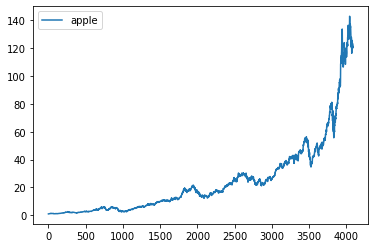

<Figure size 432x288 with 0 Axes>

In [7]:
# Plot the Adj_Close columns for apple
apple['Adj Close'].plot(label='apple', legend=True)

plt.show() # show the plot
plt.clf()  # clear the plot space

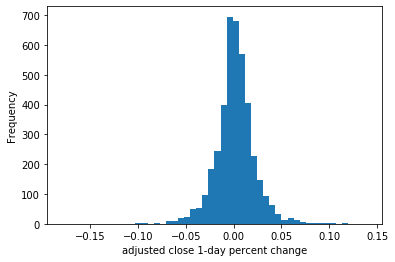

In [8]:
# Histogram of the daily price change percent of Adj_Close for Apple
apple['Adj Close'].pct_change().plot.hist(bins=50)
plt.xlabel('adjusted close 1-day percent change')
plt.show()

In [9]:
# Create 5-day % changes of Adj_Close for the current day, and 5 days in the future
apple['5d_future_close'] = apple['Adj Close'].shift(-5)
apple['5d_close_future_pct'] = apple['5d_future_close'].pct_change(5)
apple['5d_close_pct'] = apple['Adj Close'].pct_change(5)

In [10]:
# Calculate the correlation matrix between the 5d close pecentage changes (current and future)
corr = apple[['5d_close_pct', '5d_close_future_pct']].corr()
print(corr)

                     5d_close_pct  5d_close_future_pct
5d_close_pct             1.000000             0.005094
5d_close_future_pct      0.005094             1.000000


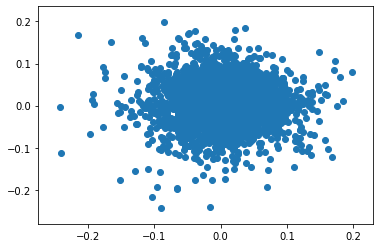

In [11]:
# Scatter the current 5-day percent change vs the future 5-day percent change
plt.scatter(apple['5d_close_pct'], apple['5d_close_future_pct'])
plt.show()

In [12]:
import talib
feature_names = ['5d_close_pct']  # a list of the feature names for later

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [5,14,30]:

    # Create the moving average indicator and divide by Adj_Close
    apple['ma' + str(n)] = talib.SMA(apple['Adj Close'].values,
                              timeperiod=n) / apple['Adj Close']
    # Create the RSI indicator
    apple['rsi' + str(n)] = talib.RSI(apple['Adj Close'].values, timeperiod=n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

print(feature_names)

['5d_close_pct', 'ma5', 'rsi5', 'ma14', 'rsi14', 'ma30', 'rsi30']


In [13]:
apple.isnull().sum()

Date                    0
Open                    0
High                    0
Low                     0
Close                   0
Adj Close               0
Volume                  0
5d_future_close         5
5d_close_future_pct     5
5d_close_pct            5
ma5                     4
rsi5                    5
ma14                   13
rsi14                  14
ma30                   29
rsi30                  30
dtype: int64

In [14]:
# Drop all na values
apple = apple.dropna()

# Create features and targets
# use feature_names for features; '5d_close_future_pct' for targets
features = apple[feature_names]
targets = apple['5d_close_future_pct']

# Create DataFrame from target column and feature columns
feature_and_target_cols = ['5d_close_future_pct'] + feature_names
feat_targ_df = apple[feature_and_target_cols]

In [15]:
# Calculate correlation matrix
corr = feat_targ_df.corr()
print(corr)

                     5d_close_future_pct  5d_close_pct       ma5      rsi5  \
5d_close_future_pct             1.000000      0.002516 -0.007087  0.017466   
5d_close_pct                    0.002516      1.000000 -0.815115  0.796991   
ma5                            -0.007087     -0.815115  1.000000 -0.766513   
rsi5                            0.017466      0.796991 -0.766513  1.000000   
ma14                           -0.006344     -0.850472  0.770873 -0.863612   
rsi14                           0.028703      0.640466 -0.564738  0.871767   
ma30                           -0.029371     -0.644468  0.565974 -0.735835   
rsi30                           0.019487      0.485658 -0.419144  0.692826   

                         ma14     rsi14      ma30     rsi30  
5d_close_future_pct -0.006344  0.028703 -0.029371  0.019487  
5d_close_pct        -0.850472  0.640466 -0.644468  0.485658  
ma5                  0.770873 -0.564738  0.565974 -0.419144  
rsi5                -0.863612  0.871767 -0.735835

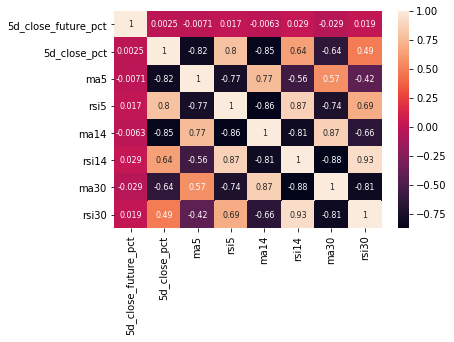

In [16]:
import seaborn as sns
# Plot heatmap of correlation matrix
sns.heatmap(corr, annot= True, annot_kws = {"size": 8})

In [17]:
# Import the statsmodels.api library with the alias sm
import statsmodels.api as sm

# Add a constant to the features
linear_features = sm.add_constant(features)

In [20]:
# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.8 * features.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

(4051, 8) (3240, 8) (811, 8)


In [21]:
# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     5d_close_future_pct   R-squared:                       0.005
Model:                             OLS   Adj. R-squared:                  0.002
Method:                  Least Squares   F-statistic:                     2.094
Date:                 Tue, 06 Apr 2021   Prob (F-statistic):             0.0409
Time:                         12:56:37   Log-Likelihood:                 5384.8
No. Observations:                 3240   AIC:                        -1.075e+04
Df Residuals:                     3232   BIC:                        -1.070e+04
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0349      0.080    

In [22]:
# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

const           0.662200
5d_close_pct    0.956336
ma5             0.043322
rsi5            0.449871
ma14            0.007423
rsi14           0.074713
ma30            0.098221
rsi30           0.047754
dtype: float64


In [23]:
# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

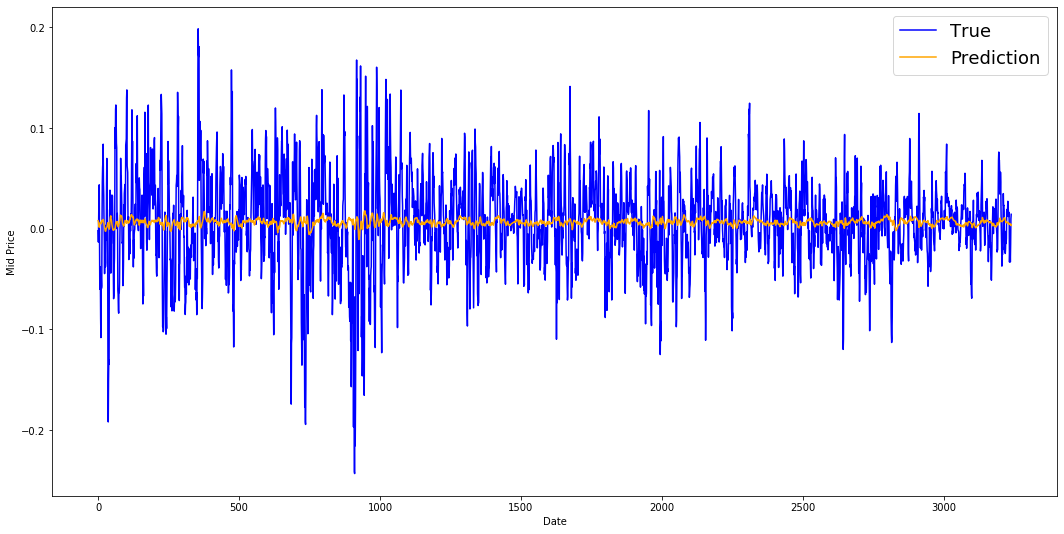

In [24]:
plt.figure(figsize = (18,9))
plt.plot(range(train_predictions.shape[0]),train_targets,color='b',label='True')
plt.plot(range(train_predictions.shape[0]),train_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

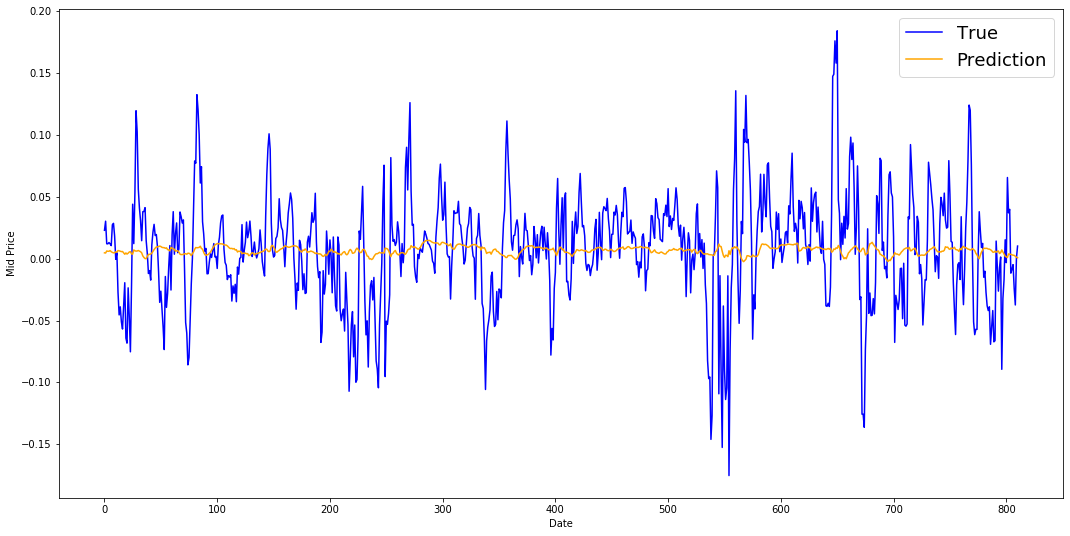

In [25]:
plt.figure(figsize = (18,9))
plt.plot(range(test_predictions.shape[0]),test_targets,color='b',label='True')
plt.plot(range(test_predictions.shape[0]),test_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

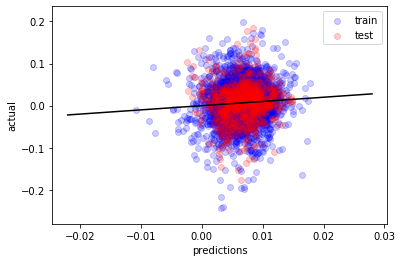

In [26]:
# Scatter the predictions vs the targets with 20% opacity
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')
# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

In [27]:
# Create 2 new volume features, 1-day % change and 5-day SMA of the % change
new_features = ['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']
feature_names.extend(new_features)
apple['Adj_Volume_1d_change'] = apple['Volume'].pct_change()
apple['Adj_Volume_1d_change_SMA'] = talib.SMA(apple['Adj_Volume_1d_change'].values,
                        timeperiod=5)

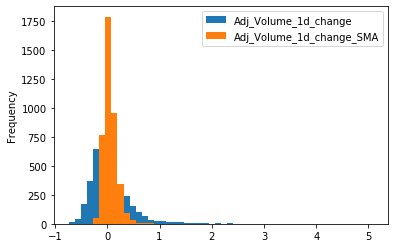

In [28]:
# Plot histogram of volume % change data
apple[new_features].plot(kind='hist', sharex=False, bins=50)
plt.show()

In [29]:
apple.isnull().sum()

Date                        0
Open                        0
High                        0
Low                         0
Close                       0
Adj Close                   0
Volume                      0
5d_future_close             0
5d_close_future_pct         0
5d_close_pct                0
ma5                         0
rsi5                        0
ma14                        0
rsi14                       0
ma30                        0
rsi30                       0
Adj_Volume_1d_change        1
Adj_Volume_1d_change_SMA    5
dtype: int64

In [30]:
train_features

,const,5d_close_pct,ma5,rsi5,ma14,rsi14,ma30,rsi30
30,1.0,0.092831,0.930551,87.670481,0.895600,80.773371,0.831837,78.060836
31,1.0,0.144653,0.938068,89.612839,0.892370,82.159350,0.825648,78.899623
32,1.0,0.120597,0.984375,70.806111,0.927196,74.371880,0.856311,74.903786
33,1.0,0.068957,1.008616,63.612682,0.946032,71.237359,0.874723,73.249540
34,1.0,0.007800,1.028139,53.320994,0.969390,66.640131,0.896580,70.791363
...,...,...,...,...,...,...,...,...
3265,1.0,0.012074,0.999713,60.000701,0.985837,59.001562,0.988249,58.902188
3266,1.0,0.016200,0.999131,64.853847,0.983736,60.561038,0.984408,59.582682
3267,1.0,0.005978,1.000320,64.853847,0.985862,60.561038,0.984363,59.582682
3268,1.0,-0.033160,1.019499,28.502939,1.011914,46.701562,1.009185,53.236710


In [31]:
features

,5d_close_pct,ma5,rsi5,ma14,rsi14,ma30,rsi30
30,0.092831,0.930551,87.670481,0.895600,80.773371,0.831837,78.060836
31,0.144653,0.938068,89.612839,0.892370,82.159350,0.825648,78.899623
32,0.120597,0.984375,70.806111,0.927196,74.371880,0.856311,74.903786
33,0.068957,1.008616,63.612682,0.946032,71.237359,0.874723,73.249540
34,0.007800,1.028139,53.320994,0.969390,66.640131,0.896580,70.791363
...,...,...,...,...,...,...,...
4076,0.065572,0.980805,59.961669,0.984256,47.447140,1.032133,47.848390
4077,0.036997,0.975599,65.578811,0.971996,50.108856,1.016924,49.137511
4078,0.039840,0.989596,60.169383,0.980465,48.745801,1.020847,48.501694
4079,-0.011725,1.021953,39.110104,1.014442,42.278022,1.053020,45.332773


In [32]:
new_features

['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']

In [33]:
features=apple[feature_names]
features

,5d_close_pct,ma5,rsi5,ma14,rsi14,ma30,rsi30,Adj_Volume_1d_change,Adj_Volume_1d_change_SMA
30,0.092831,0.930551,87.670481,0.895600,80.773371,0.831837,78.060836,NaN,NaN
31,0.144653,0.938068,89.612839,0.892370,82.159350,0.825648,78.899623,-0.291051,NaN
32,0.120597,0.984375,70.806111,0.927196,74.371880,0.856311,74.903786,-0.073674,NaN
33,0.068957,1.008616,63.612682,0.946032,71.237359,0.874723,73.249540,-0.233932,NaN
34,0.007800,1.028139,53.320994,0.969390,66.640131,0.896580,70.791363,0.048175,NaN
...,...,...,...,...,...,...,...,...,...
4076,0.065572,0.980805,59.961669,0.984256,47.447140,1.032133,47.848390,0.050480,-0.093923
4077,0.036997,0.975599,65.578811,0.971996,50.108856,1.016924,49.137511,0.241724,-0.013407
4078,0.039840,0.989596,60.169383,0.980465,48.745801,1.020847,48.501694,-0.028782,0.007779
4079,-0.011725,1.021953,39.110104,1.014442,42.278022,1.053020,45.332773,0.087872,0.041471


In [34]:
apple=apple.dropna()

In [35]:
apple

,Date,Open,High,Low,Close,Adj Close,Volume,5d_future_close,5d_close_future_pct,5d_close_pct,ma5,rsi5,ma14,rsi14,ma30,rsi30,Adj_Volume_1d_change,Adj_Volume_1d_change_SMA
35,2005-02-23,1.548571,1.579464,1.527679,1.575536,1.357109,1345181600,1.357263,0.000113,-0.002035,0.993472,66.446259,0.944050,70.593205,0.873985,72.629304,0.103247,-0.089447
36,2005-02-24,1.580000,1.594821,1.566607,1.588036,1.367876,1519028000,1.285585,-0.060160,-0.013314,0.982953,69.037386,0.945551,71.460362,0.876240,73.047043,0.129236,-0.005390
37,2005-02-25,1.600357,1.605536,1.574821,1.589107,1.368799,915510400,1.316963,-0.037870,0.013438,0.984942,69.291497,0.953060,71.537846,0.884462,73.083473,-0.397305,-0.070116
38,2005-02-28,1.595714,1.612143,1.570000,1.602143,1.380027,651610400,1.315117,-0.047035,0.033521,0.983415,72.698573,0.953888,72.515390,0.884667,73.533646,-0.288255,-0.080980
39,2005-03-01,1.606786,1.611071,1.577143,1.589286,1.368953,468188000,1.246823,-0.089214,0.043498,0.999708,63.951087,0.968106,69.963132,0.898865,72.299906,-0.281491,-0.146913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4076,2021-03-15,121.410004,124.000000,120.419998,123.989998,123.989998,92403800,123.389999,-0.004839,0.065572,0.980805,59.961669,0.984256,47.447140,1.032133,47.848390,0.050480,-0.093923
4077,2021-03-16,125.699997,127.220001,124.720001,125.570000,125.570000,114740000,122.540001,-0.024130,0.036997,0.975599,65.578811,0.971996,50.108856,1.016924,49.137511,0.241724,-0.013407
4078,2021-03-17,124.050003,125.860001,122.339996,124.760002,124.760002,111437500,120.089996,-0.037432,0.039840,0.989596,60.169383,0.980465,48.745801,1.020847,48.501694,-0.028782,0.007779
4079,2021-03-18,122.879997,123.180000,120.320000,120.529999,120.529999,121229700,120.589996,0.000498,-0.011725,1.021953,39.110104,1.014442,42.278022,1.053020,45.332773,0.087872,0.041471


In [36]:
features=apple[feature_names]
features

,5d_close_pct,ma5,rsi5,ma14,rsi14,ma30,rsi30,Adj_Volume_1d_change,Adj_Volume_1d_change_SMA
35,-0.002035,0.993472,66.446259,0.944050,70.593205,0.873985,72.629304,0.103247,-0.089447
36,-0.013314,0.982953,69.037386,0.945551,71.460362,0.876240,73.047043,0.129236,-0.005390
37,0.013438,0.984942,69.291497,0.953060,71.537846,0.884462,73.083473,-0.397305,-0.070116
38,0.033521,0.983415,72.698573,0.953888,72.515390,0.884667,73.533646,-0.288255,-0.080980
39,0.043498,0.999708,63.951087,0.968106,69.963132,0.898865,72.299906,-0.281491,-0.146913
...,...,...,...,...,...,...,...,...,...
4076,0.065572,0.980805,59.961669,0.984256,47.447140,1.032133,47.848390,0.050480,-0.093923
4077,0.036997,0.975599,65.578811,0.971996,50.108856,1.016924,49.137511,0.241724,-0.013407
4078,0.039840,0.989596,60.169383,0.980465,48.745801,1.020847,48.501694,-0.028782,0.007779
4079,-0.011725,1.021953,39.110104,1.014442,42.278022,1.053020,45.332773,0.087872,0.041471


In [37]:
targets = apple['5d_close_future_pct']

In [38]:
# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * features.shape[0])
train_features = features[:train_size]
train_targets = targets[:train_size]
test_features = features[train_size:]
test_targets = targets[train_size:]
print(features.shape, train_features.shape, test_features.shape,test_targets.shape)

(4046, 9) (3439, 9) (607, 9) (607,)


In [39]:
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regression model with default arguments
decision_tree = DecisionTreeRegressor()

# Fit the model to the training features and targets
decision_tree.fit(train_features,train_targets)

# Check the score on train and test
print(decision_tree.score(train_features, train_targets))
print(decision_tree.score(test_features,test_targets))

0.999998308421293
-1.247886570487585


In [40]:
# Loop through a few different max depths and check the performance
for d in [3,5,10,15,20,25]:
    # Create the tree and fit it
    decision_tree = DecisionTreeRegressor(max_depth=d)
    decision_tree.fit(train_features, train_targets)

    # Print out the scores on train and test
    print('max_depth=', str(d))
    print(decision_tree.score(train_features,train_targets))
    print(decision_tree.score(test_features, test_targets), '\n')

max_depth= 3
0.044596623640908106
-0.08045649880978467 

max_depth= 5
0.1104710300192725
-0.23507095126323896 

max_depth= 10
0.2810554143195267
-0.381830666851992 

max_depth= 15
0.5181790603357304
-0.7483634056825159 

max_depth= 20
0.7929570850030065
-0.9888126281003026 

max_depth= 25
0.9429413278041754
-1.0795986691918924 



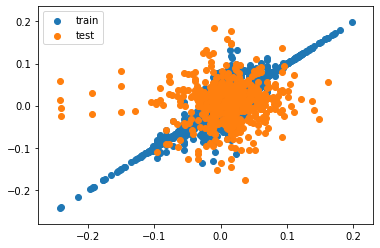

In [41]:
# Use the best max_depth of 3 from last exercise to fit a decision tree
decision_tree = DecisionTreeRegressor(max_depth=20)
decision_tree.fit(train_features, train_targets)

# Predict values for train and test
train_predictions = decision_tree.predict(train_features)
test_predictions = decision_tree.predict(test_features)

# Scatter the predictions vs actual values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions,test_targets,label='test')
plt.legend()
plt.show()

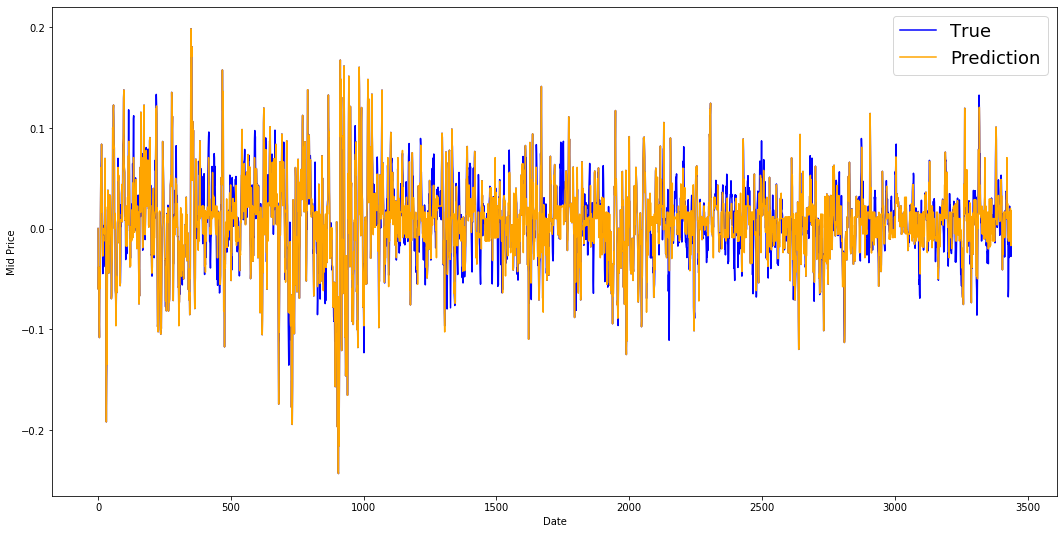

In [42]:
plt.figure(figsize = (18,9))
plt.plot(range(train_predictions.shape[0]),train_targets,color='b',label='True')
plt.plot(range(train_predictions.shape[0]),train_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

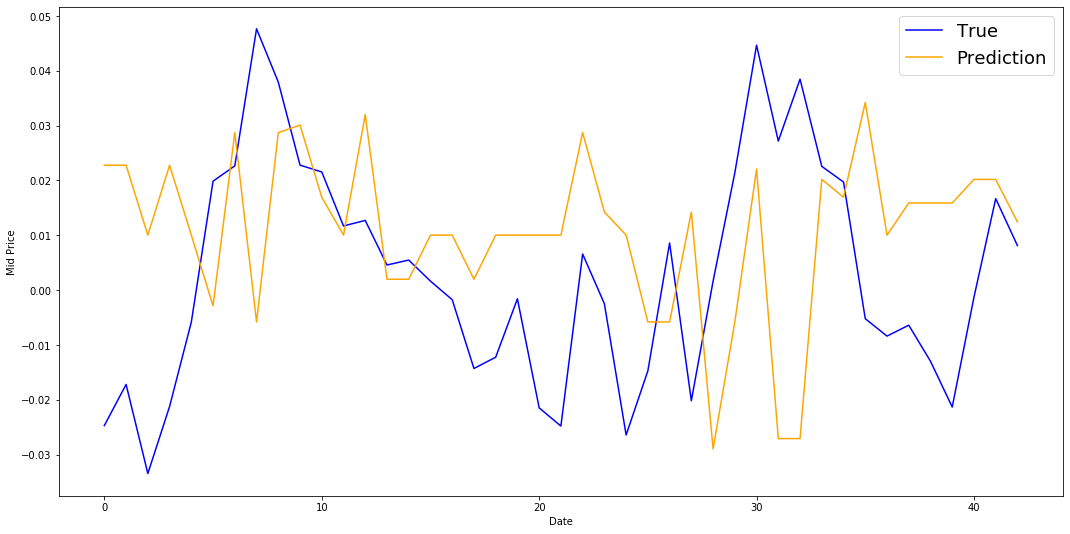

In [144]:
plt.figure(figsize = (18,9))
plt.plot(range(test_predictions.shape[0]),test_targets,color='b',label='True')
plt.plot(range(test_predictions.shape[0]),test_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [43]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(train_features, train_targets)

# Look at the R^2 scores on train and test
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features,test_targets))

0.8699541748700388
-0.19341062932640507


In [44]:
from sklearn.model_selection import ParameterGrid

# Create a dictionary of hyperparameters to search
grid = {'n_estimators':[200], 'max_depth': [3,5,10,15,20,25], 'max_features': [4,6], 'random_state': [42]}
test_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # ** is "unpacking" the dictionary
    rfr.fit(train_features, train_targets)
    test_scores.append(rfr.score(test_features, test_targets))
    print(g)
    print(rfr.score(train_features, train_targets))
    print(rfr.score(test_features,test_targets))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

{'max_depth': 3, 'max_features': 4, 'n_estimators': 200, 'random_state': 42}
0.056221017400645
-0.034801729770259415
{'max_depth': 3, 'max_features': 6, 'n_estimators': 200, 'random_state': 42}
0.059744966364239205
-0.05584243128023103
{'max_depth': 5, 'max_features': 4, 'n_estimators': 200, 'random_state': 42}
0.11273150217114003
-0.05729628222999162
{'max_depth': 5, 'max_features': 6, 'n_estimators': 200, 'random_state': 42}
0.11997420532983749
-0.08494490699559054
{'max_depth': 10, 'max_features': 4, 'n_estimators': 200, 'random_state': 42}
0.2865085843519457
-0.11188851687668076
{'max_depth': 10, 'max_features': 6, 'n_estimators': 200, 'random_state': 42}
0.2971946643417608
-0.13255812655841548
{'max_depth': 15, 'max_features': 4, 'n_estimators': 200, 'random_state': 42}
0.5085146138646988
-0.13363374111549553
{'max_depth': 15, 'max_features': 6, 'n_estimators': 200, 'random_state': 42}
0.5115130241692214
-0.14982438406043164
{'max_depth': 20, 'max_features': 4, 'n_estimators': 200

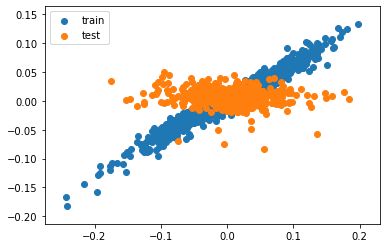

In [45]:
# Use the best hyperparameters from before to fit a random forest model
rfr = RandomForestRegressor(n_estimators=200, max_depth=25, max_features=4, random_state=42)
rfr.fit(train_features, train_targets)

# Make predictions with our model
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Create a scatter plot with train and test actual vs predictions
plt.scatter(train_targets, train_predictions, label='train')
plt.scatter(test_targets,test_predictions,label='test')
plt.legend()
plt.show()

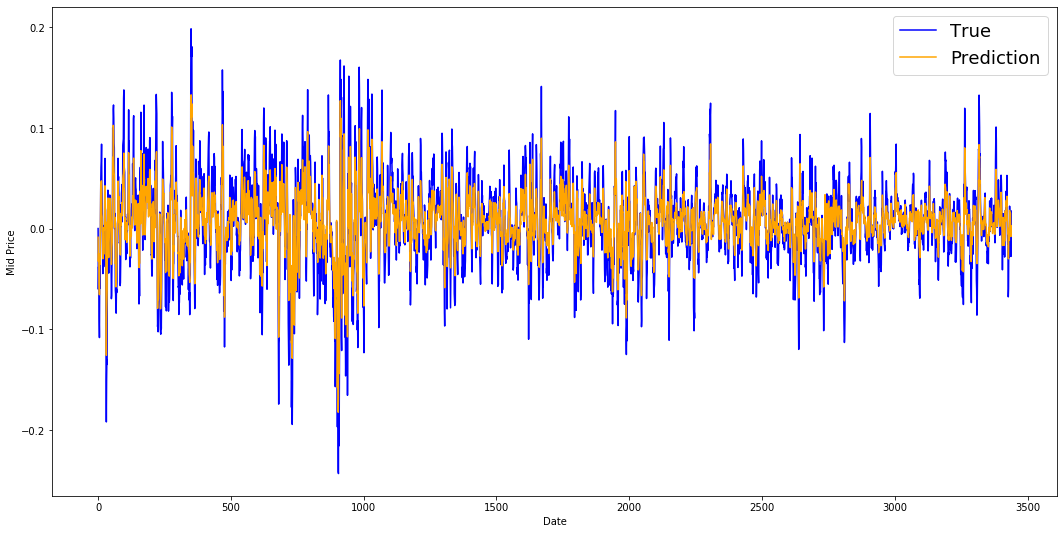

In [46]:
plt.figure(figsize = (18,9))
plt.plot(range(train_predictions.shape[0]),train_targets,color='b',label='True')
plt.plot(range(train_predictions.shape[0]),train_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

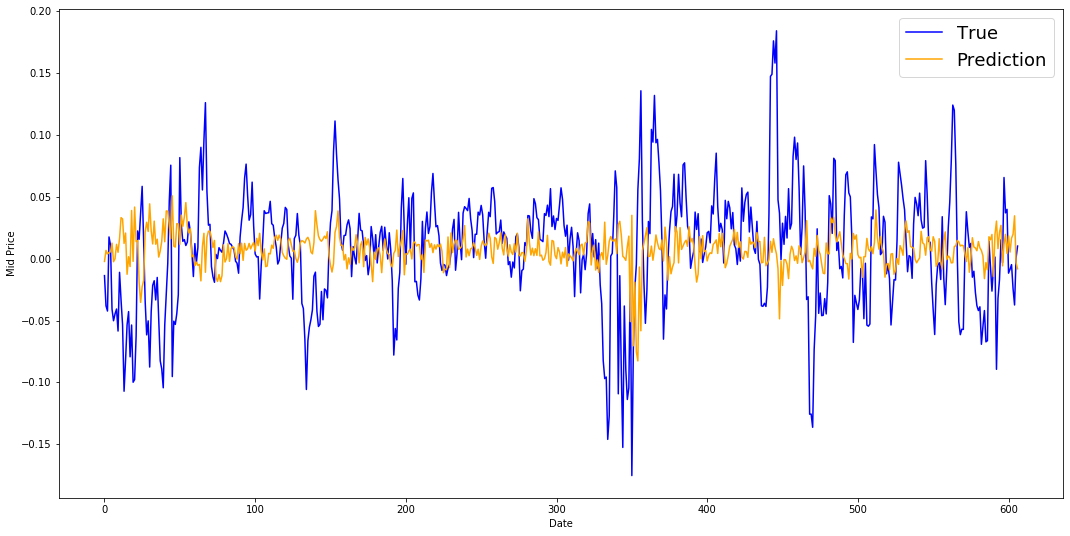

In [47]:
plt.figure(figsize = (18,9))
plt.plot(range(test_predictions.shape[0]),test_targets,color='b',label='True')
plt.plot(range(test_predictions.shape[0]),test_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

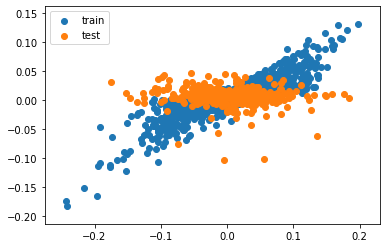

In [48]:
# Use the best hyperparameters from before to fit a random forest model
rfr = RandomForestRegressor(n_estimators=200, max_depth=15, max_features=6, random_state=42)
rfr.fit(train_features, train_targets)

# Make predictions with our model
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Create a scatter plot with train and test actual vs predictions
plt.scatter(train_targets, train_predictions, label='train')
plt.scatter(test_targets,test_predictions,label='test')
plt.legend()
plt.show()

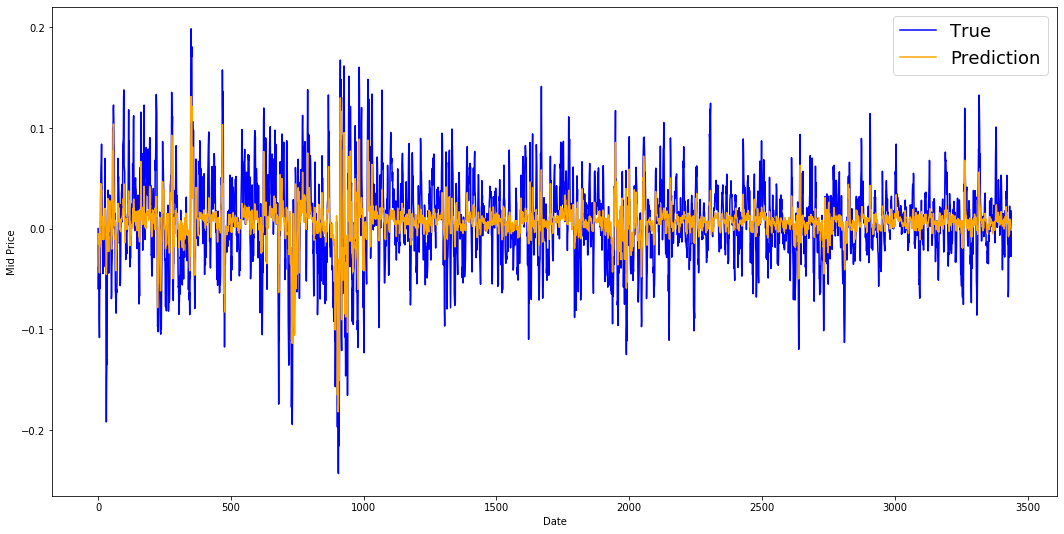

In [49]:
plt.figure(figsize = (18,9))
plt.plot(range(train_predictions.shape[0]),train_targets,color='b',label='True')
plt.plot(range(train_predictions.shape[0]),train_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

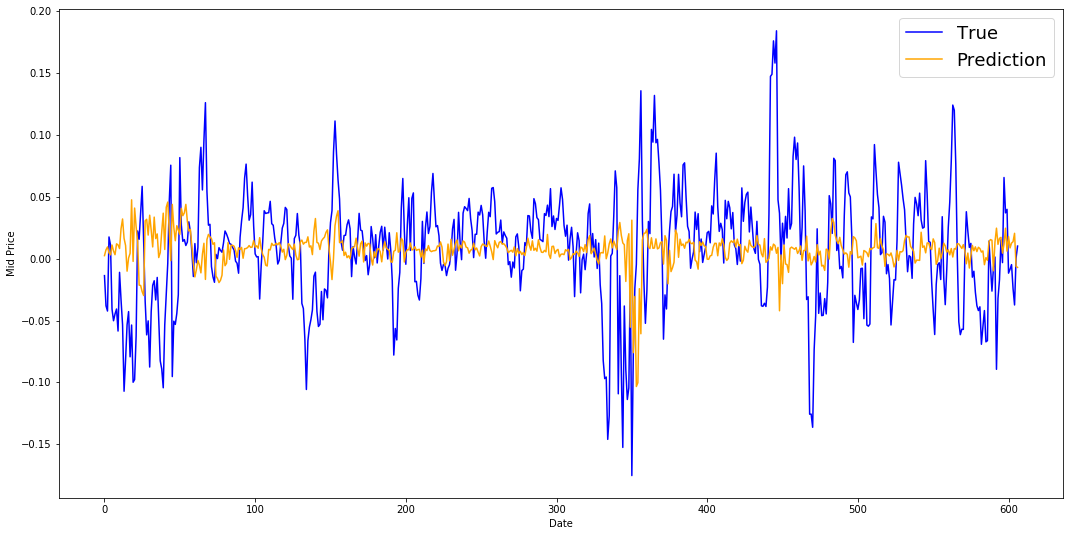

In [50]:
plt.figure(figsize = (18,9))
plt.plot(range(test_predictions.shape[0]),test_targets,color='b',label='True')
plt.plot(range(test_predictions.shape[0]),test_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

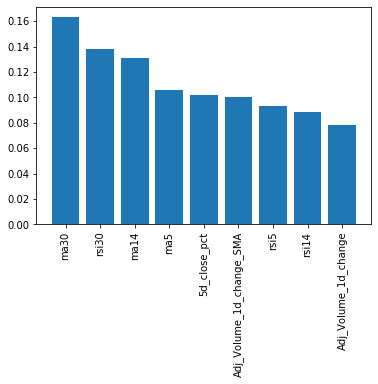

In [51]:
# Get feature importances from our random forest model
importances = rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

In [52]:
from sklearn.ensemble import GradientBoostingRegressor

# Create GB model -- hyperparameters have already been searched for you
gbr =GradientBoostingRegressor(max_features=5,
                                learning_rate=0.0075,
                                n_estimators=200,
                                subsample=0.6,
                                random_state=42)
gbr.fit(train_features,train_targets)

print(gbr.score(train_features, train_targets))
print(gbr.score(test_features,test_targets))

0.07259756725605815
-0.04196378157071812


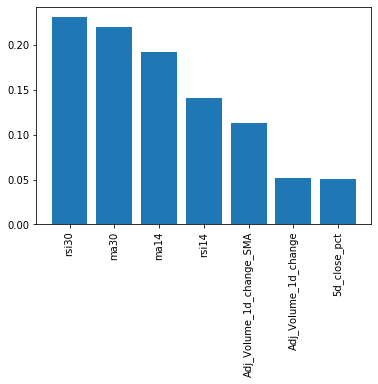

In [156]:
# Extract feature importances from the fitted gradient boosting model
feature_importances = gbr.feature_importances_

# Get the indices of the largest to smallest feature importances
sorted_index = np.argsort(feature_importances)[::-1]
x = range(features.shape[1])

# Create tick labels 
labels = np.array(feature_names)[sorted_index]

plt.bar(x, feature_importances[sorted_index], tick_label=labels)

# Set the tick lables to be the feature names, according to the sorted feature_idx
plt.xticks(rotation=90)
plt.show()

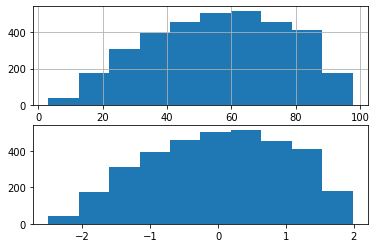

In [53]:
# Standardize the train and test features
from sklearn.preprocessing import scale

scaled_train_features = scale(train_features)
scaled_test_features = scale(test_features)

# Plot histograms of the 14-day SMA RSI before and after scaling
f, ax = plt.subplots(nrows=2, ncols=1)
train_features.iloc[:, 2].hist(ax=ax[0])
ax[1].hist(scaled_train_features[:, 2])
plt.show()

In [54]:
from sklearn.neighbors import KNeighborsRegressor

for n in range(2,26):
    # Create and fit the KNN model
    knn = KNeighborsRegressor(n_neighbors=n)
    
    # Fit the model to the training data
    knn.fit(scaled_train_features, train_targets)
    
    # Print number of neighbors and the score to find the best value of n
    print("n_neighbors =", n)
    print('train, test scores')
    print(knn.score(scaled_train_features, train_targets))
    print(knn.score(scaled_test_features, test_targets))
    print()  # prints a blank line

n_neighbors = 2
train, test scores
0.5769499712664358
-0.6373813646326676

n_neighbors = 3
train, test scores
0.4041066197588664
-0.4349319817063384

n_neighbors = 4
train, test scores
0.3158024971161992
-0.334986121347135

n_neighbors = 5
train, test scores
0.26537757257931793
-0.2842083980487191

n_neighbors = 6
train, test scores
0.23471836570589077
-0.24239176353143432

n_neighbors = 7
train, test scores
0.21210234843101383
-0.22487386576851898

n_neighbors = 8
train, test scores
0.18936087806767954
-0.18847545188996895

n_neighbors = 9
train, test scores
0.1693770811803671
-0.17349601017994054

n_neighbors = 10
train, test scores
0.15530560536667137
-0.17121644557705573

n_neighbors = 11
train, test scores
0.1424713882844012
-0.15163693924813737

n_neighbors = 12
train, test scores
0.1277674589502681
-0.1501611461458776

n_neighbors = 13
train, test scores
0.11772323648725236
-0.13707311770810882

n_neighbors = 14
train, test scores
0.1055843021675762
-0.1313965598799569

n_neighb

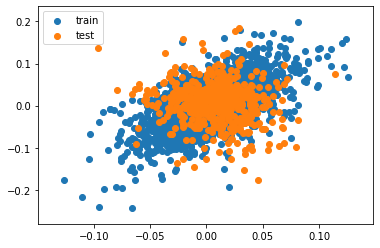

In [55]:
# Create the model with the best-performing n_neighbors of 9
knn = KNeighborsRegressor(n_neighbors=3)

# Fit the model
knn.fit(scaled_train_features, train_targets)

# Get predictions for train and test sets
train_predictions = knn.predict(scaled_train_features)
test_predictions = knn.predict(scaled_test_features)

# Plot the actual vs predicted values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions,test_targets,label='test')
plt.legend()
plt.show()

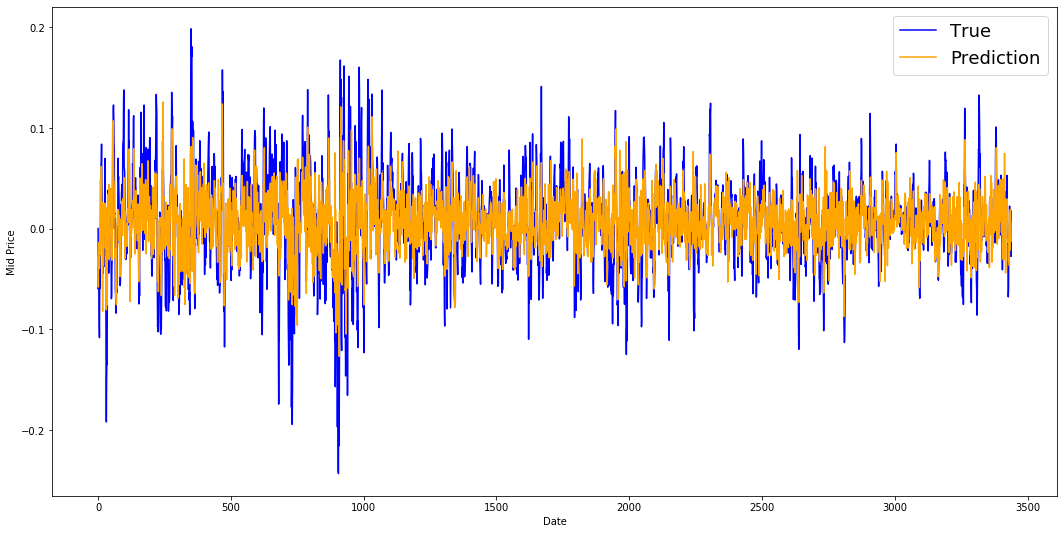

In [56]:
plt.figure(figsize = (18,9))
plt.plot(range(train_predictions.shape[0]),train_targets,color='b',label='True')
plt.plot(range(train_predictions.shape[0]),train_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

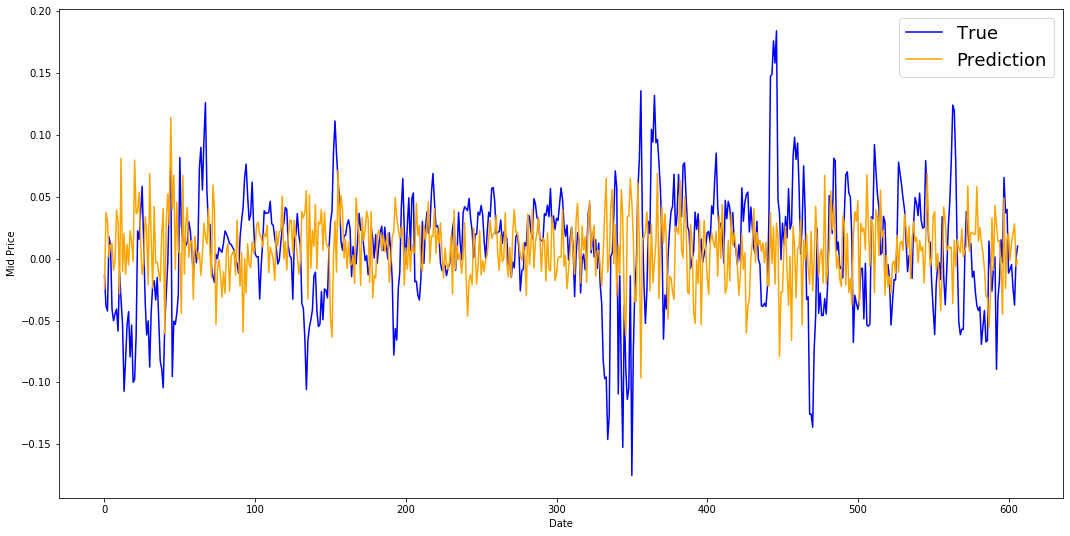

In [57]:
plt.figure(figsize = (18,9))
plt.plot(range(test_predictions.shape[0]),test_targets,color='b',label='True')
plt.plot(range(test_predictions.shape[0]),test_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [58]:
from keras.models import Sequential
from keras.layers import Dense

# Create the model
model_1 = Sequential()
model_1.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_1.add(Dense(25, activation='relu'))
model_1.add(Dense(1, activation='linear'))

# Fit the model
model_1.compile(optimizer='adam', loss='mse')
history = model_1.fit(scaled_train_features, train_targets, epochs=300)

Using TensorFlow backend.



Epoch 1/300
3439/3439 [==============================] - 1s 164us/step - loss: 0.0050
Epoch 2/300
3439/3439 [==============================] - 0s 34us/step - loss: 0.0029
Epoch 3/300
3439/3439 [==============================] - 0s 33us/step - loss: 0.0026
Epoch 4/300
3439/3439 [==============================] - 0s 34us/step - loss: 0.0025
Epoch 5/300
3439/3439 [==============================] - 0s 33us/step - loss: 0.0025: 0s - loss: 0.00
Epoch 6/300
3439/3439 [==============================] - 0s 33us/step - loss: 0.0023
Epoch 7/300
3439/3439 [==============================] - 0s 36us/step - loss: 0.0021
Epoch 8/300
3439/3439 [==============================] - 0s 32us/step - loss: 0.0021
Epoch 9/300
3439/3439 [==============================] - 0s 33us/step - loss: 0.0021
Epoch 10/300
3439/3439 [==============================] - 0s 52us/step - loss: 0.0021
Epoch 11/300
3439/3439 [==============================] - 0s 33us/step - loss: 0.0021
Epoch 12/300
3439/3439 [====================

3439/3439 [==============================] - 0s 34us/step - loss: 0.0014
Epoch 94/300
3439/3439 [==============================] - 0s 32us/step - loss: 0.0014
Epoch 95/300
3439/3439 [==============================] - 0s 33us/step - loss: 0.0014
Epoch 96/300
3439/3439 [==============================] - 0s 31us/step - loss: 0.0014
Epoch 97/300
3439/3439 [==============================] - 0s 31us/step - loss: 0.0013
Epoch 98/300
3439/3439 [==============================] - 0s 32us/step - loss: 0.0013
Epoch 99/300
3439/3439 [==============================] - 0s 32us/step - loss: 0.0014
Epoch 100/300
3439/3439 [==============================] - 0s 32us/step - loss: 0.0013
Epoch 101/300
3439/3439 [==============================] - 0s 37us/step - loss: 0.0013
Epoch 102/300
3439/3439 [==============================] - 0s 33us/step - loss: 0.0013
Epoch 103/300
3439/3439 [==============================] - 0s 34us/step - loss: 0.0014
Epoch 104/300
3439/3439 [==============================] - 0s 3

3439/3439 [==============================] - 0s 65us/step - loss: 0.0010
Epoch 188/300
3439/3439 [==============================] - 0s 55us/step - loss: 0.0011
Epoch 189/300
3439/3439 [==============================] - 0s 52us/step - loss: 9.9321e-04
Epoch 190/300
3439/3439 [==============================] - 0s 66us/step - loss: 0.0010
Epoch 191/300
3439/3439 [==============================] - 0s 75us/step - loss: 0.0010
Epoch 192/300
3439/3439 [==============================] - 0s 73us/step - loss: 0.0010
Epoch 193/300
3439/3439 [==============================] - 0s 46us/step - loss: 9.6713e-04
Epoch 194/300
3439/3439 [==============================] - 0s 66us/step - loss: 0.0010
Epoch 195/300
3439/3439 [==============================] - 0s 54us/step - loss: 0.0011
Epoch 196/300
3439/3439 [==============================] - 0s 54us/step - loss: 0.0010
Epoch 197/300
3439/3439 [==============================] - 0s 61us/step - loss: 0.0010
Epoch 198/300
3439/3439 [========================

3439/3439 [==============================] - 0s 65us/step - loss: 8.2846e-04
Epoch 279/300
3439/3439 [==============================] - 0s 53us/step - loss: 8.8645e-04
Epoch 280/300
3439/3439 [==============================] - 0s 48us/step - loss: 9.2697e-04
Epoch 281/300
3439/3439 [==============================] - 0s 65us/step - loss: 9.2289e-04
Epoch 282/300
3439/3439 [==============================] - 0s 48us/step - loss: 8.5193e-04
Epoch 283/300
3439/3439 [==============================] - 0s 56us/step - loss: 8.3339e-04
Epoch 284/300
3439/3439 [==============================] - 0s 52us/step - loss: 8.3523e-04
Epoch 285/300
3439/3439 [==============================] - 0s 51us/step - loss: 8.2015e-04
Epoch 286/300
3439/3439 [==============================] - 0s 56us/step - loss: 8.6165e-04
Epoch 287/300
3439/3439 [==============================] - 0s 54us/step - loss: 8.2911e-04
Epoch 288/300
3439/3439 [==============================] - 0s 58us/step - loss: 8.4920e-04
Epoch 289/300

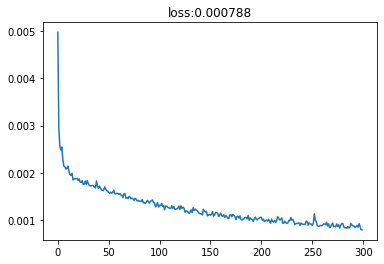

In [59]:
# Plot the losses from the fit
plt.plot(history.history['loss'])

# Use the last loss as the title
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

0.6439242386202608
-0.6024024867814222


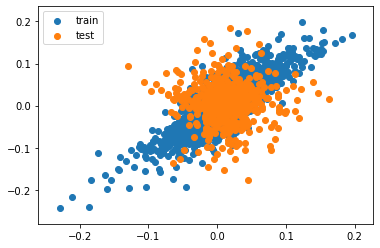

In [60]:
from sklearn.metrics import r2_score

# Calculate R^2 score
train_preds = model_1.predict(scaled_train_features)
test_preds = model_1.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Plot predictions vs actual
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds,test_targets,label='test')
plt.legend()
plt.show()

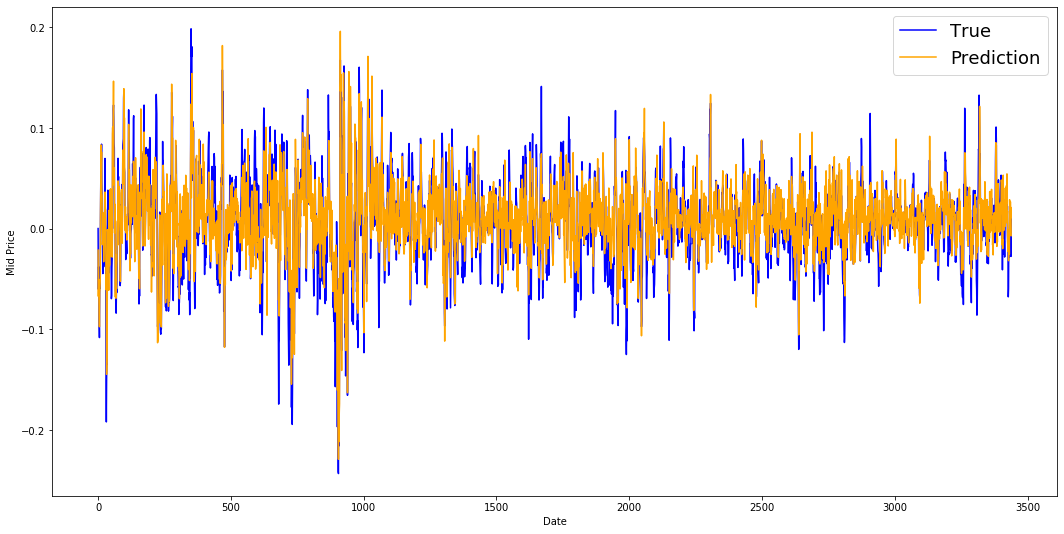

In [61]:
plt.figure(figsize = (18,9))
plt.plot(range(train_preds.shape[0]),train_targets,color='b',label='True')
plt.plot(range(train_preds.shape[0]),train_preds,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

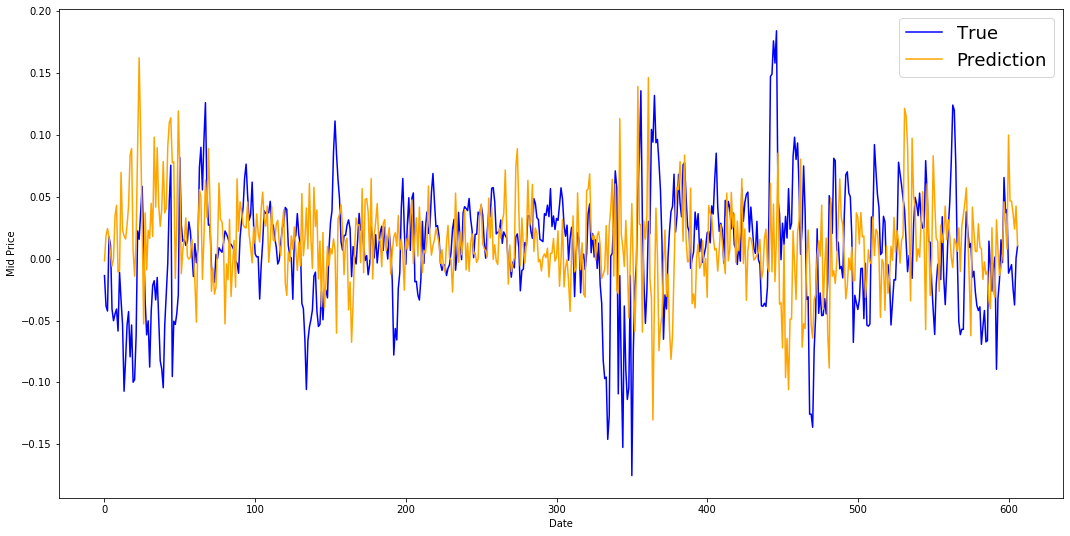

In [62]:
plt.figure(figsize = (18,9))
plt.plot(range(test_preds.shape[0]),test_targets,color='b',label='True')
plt.plot(range(test_preds.shape[0]),test_preds,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [63]:
import keras.losses
import tensorflow as tf

# Create loss function
def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true * y_pred, 0), \
                     penalty * tf.square(y_true - y_pred), \
                     tf.square(y_true - y_pred))

    return tf.reduce_mean(loss, axis=-1)

keras.losses.sign_penalty = sign_penalty  # enable use of loss with keras
print(keras.losses.sign_penalty)

<function sign_penalty at 0x00000259C6BF8318>


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/25
3439/3439 [==============================] - 0s 143us/step - loss: 0.6592
Epoch 2/25
3439/3439 [==============================] - 0s 50us/step - loss: 0.1966
Epoch 3/25
3439/3439 [==============================] - 0s 58us/step - loss: 0.1588
Epoch 4/25
3439/3439 [==============================] - 0s 55us/step - loss: 0.1539
Epoch 5/25
3439/3439 [==============================] - 0s 55us/step - loss: 0.1316
Epoch 6/25
3439/3439 [==============================] - 0s 56us/step - loss: 0.1283
Epoch 7/25
3439/3439 [==============================] - 0s 53us/step - loss: 0.1209
Epoch 8/25
3439/3439 [==============================] - 0s 56us/step - loss: 0.1248
Epoch 9/25
3439/3439 [==============================] - 0s 60us/step - loss: 0.1186
Epoch 10/25
3439/3439 [==============================] - 0s 69us/step - loss: 0.1182
Epoch 11/25
3439/3439 [==============================] - 0s 89us

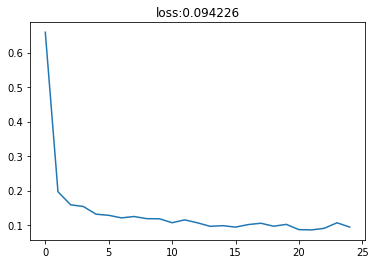

In [64]:
# Create the model
model_2 = Sequential()
model_2.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_2.add(Dense(20, activation='relu'))
model_2.add(Dense(1, activation='linear'))

# Fit the model with our custom 'sign_penalty' loss function
model_2.compile(optimizer='adam', loss=sign_penalty)
history = model_2.fit(scaled_train_features, train_targets, epochs=25)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

0.0208317598366079
-0.06064365765121593


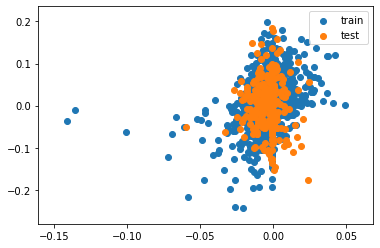

In [65]:
# Evaluate R^2 scores
train_preds = model_2.predict(scaled_train_features)
test_preds = model_2.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets,test_preds))

# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds,test_targets,label='test')  # plot test set
plt.legend(); plt.show()

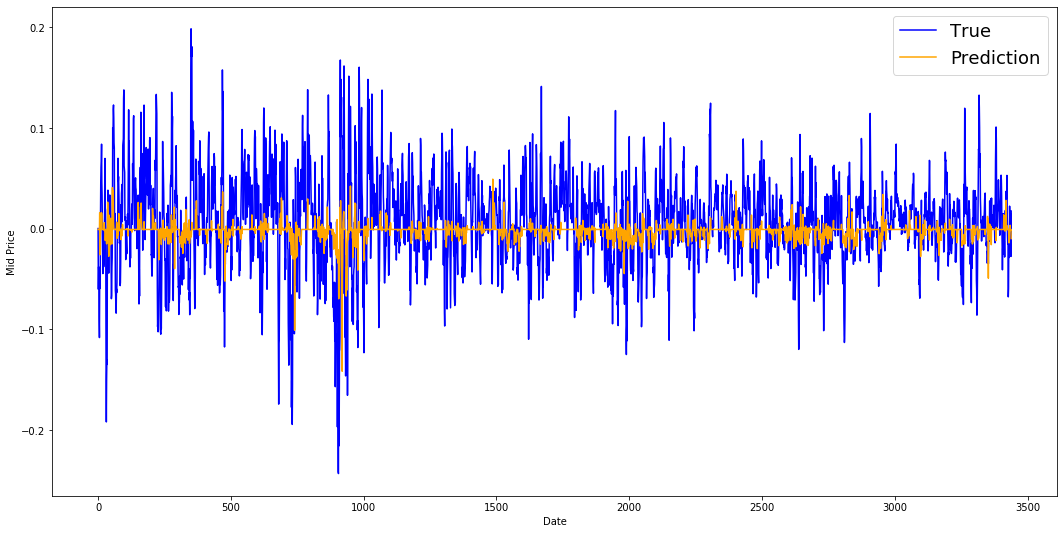

In [66]:
plt.figure(figsize = (18,9))
plt.plot(range(train_preds.shape[0]),train_targets,color='b',label='True')
plt.plot(range(train_preds.shape[0]),train_preds,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

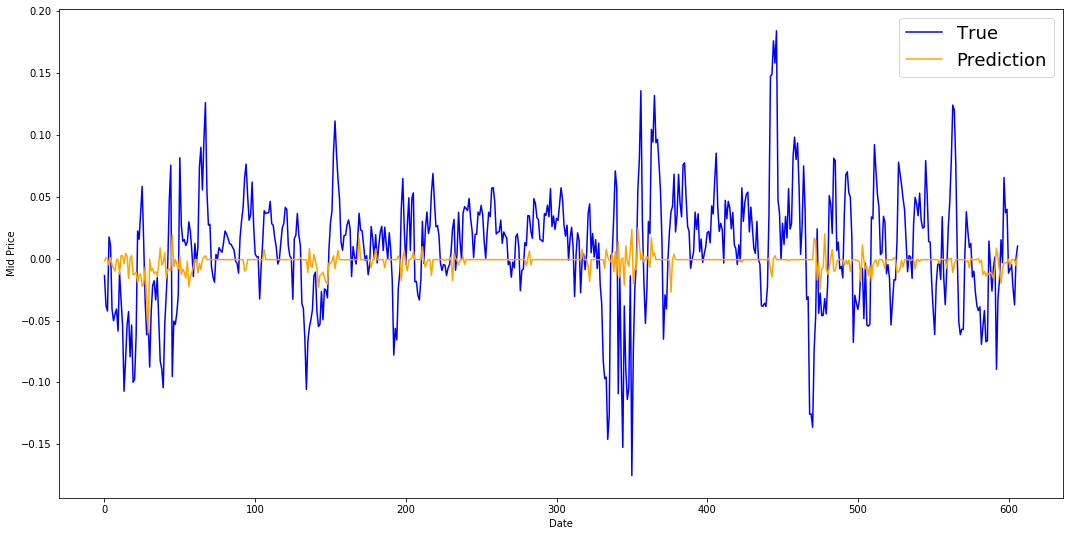

In [67]:
plt.figure(figsize = (18,9))
plt.plot(range(test_preds.shape[0]),test_targets,color='b',label='True')
plt.plot(range(test_preds.shape[0]),test_preds,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

Epoch 1/300
3439/3439 [==============================] - 1s 155us/step - loss: 0.0296
Epoch 2/300
3439/3439 [==============================] - 0s 60us/step - loss: 0.0083
Epoch 3/300
3439/3439 [==============================] - 0s 45us/step - loss: 0.0056
Epoch 4/300
3439/3439 [==============================] - 0s 45us/step - loss: 0.0044
Epoch 5/300
3439/3439 [==============================] - 0s 62us/step - loss: 0.0038
Epoch 6/300
3439/3439 [==============================] - 0s 52us/step - loss: 0.0032
Epoch 7/300
3439/3439 [==============================] - 0s 48us/step - loss: 0.0030
Epoch 8/300
3439/3439 [==============================] - 0s 48us/step - loss: 0.0027
Epoch 9/300
3439/3439 [==============================] - 0s 49us/step - loss: 0.0026
Epoch 10/300
3439/3439 [==============================] - 0s 46us/step - loss: 0.0024
Epoch 11/300
3439/3439 [==============================] - 0s 48us/step - loss: 0.0023
Epoch 12/300
3439/3439 [==============================] - 0s 5

3439/3439 [==============================] - 0s 59us/step - loss: 0.0017
Epoch 97/300
3439/3439 [==============================] - 0s 53us/step - loss: 0.0018
Epoch 98/300
3439/3439 [==============================] - 0s 54us/step - loss: 0.0018
Epoch 99/300
3439/3439 [==============================] - 0s 78us/step - loss: 0.0017
Epoch 100/300
3439/3439 [==============================] - 0s 106us/step - loss: 0.0018
Epoch 101/300
3439/3439 [==============================] - 0s 125us/step - loss: 0.0018
Epoch 102/300
3439/3439 [==============================] - 0s 106us/step - loss: 0.0017
Epoch 103/300
3439/3439 [==============================] - 0s 78us/step - loss: 0.0017
Epoch 104/300
3439/3439 [==============================] - 0s 56us/step - loss: 0.0017
Epoch 105/300
3439/3439 [==============================] - 0s 67us/step - loss: 0.0017
Epoch 106/300
3439/3439 [==============================] - 0s 90us/step - loss: 0.0017
Epoch 107/300
3439/3439 [==============================] 

3439/3439 [==============================] - 0s 57us/step - loss: 0.0016
Epoch 191/300
3439/3439 [==============================] - 0s 65us/step - loss: 0.0015
Epoch 192/300
3439/3439 [==============================] - 0s 56us/step - loss: 0.0016
Epoch 193/300
3439/3439 [==============================] - 0s 54us/step - loss: 0.0016
Epoch 194/300
3439/3439 [==============================] - 0s 51us/step - loss: 0.0015
Epoch 195/300
3439/3439 [==============================] - 0s 72us/step - loss: 0.0015
Epoch 196/300
3439/3439 [==============================] - 0s 50us/step - loss: 0.0015
Epoch 197/300
3439/3439 [==============================] - 0s 47us/step - loss: 0.0015
Epoch 198/300
3439/3439 [==============================] - 0s 48us/step - loss: 0.0015
Epoch 199/300
3439/3439 [==============================] - 0s 48us/step - loss: 0.0015
Epoch 200/300
3439/3439 [==============================] - 0s 51us/step - loss: 0.0015
Epoch 201/300
3439/3439 [==============================] 

3439/3439 [==============================] - 0s 60us/step - loss: 0.0014
Epoch 285/300
3439/3439 [==============================] - 0s 48us/step - loss: 0.0015
Epoch 286/300
3439/3439 [==============================] - 0s 58us/step - loss: 0.0015
Epoch 287/300
3439/3439 [==============================] - 0s 52us/step - loss: 0.0015
Epoch 288/300
3439/3439 [==============================] - 0s 59us/step - loss: 0.0015
Epoch 289/300
3439/3439 [==============================] - 0s 52us/step - loss: 0.0014
Epoch 290/300
3439/3439 [==============================] - 0s 59us/step - loss: 0.0014
Epoch 291/300
3439/3439 [==============================] - 0s 51us/step - loss: 0.0015
Epoch 292/300
3439/3439 [==============================] - 0s 65us/step - loss: 0.0015
Epoch 293/300
3439/3439 [==============================] - 0s 64us/step - loss: 0.0014
Epoch 294/300
3439/3439 [==============================] - 0s 51us/step - loss: 0.0015
Epoch 295/300
3439/3439 [==============================] 

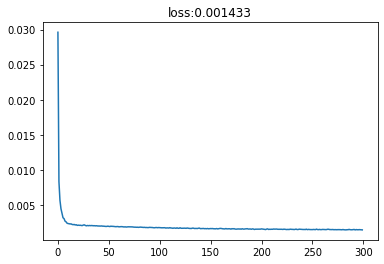

In [68]:
from keras.layers import Dropout

# Create model with dropout
model_3 = Sequential()
model_3.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(20, activation='relu'))
model_3.add(Dense(1, activation='linear'))

# Fit model with mean squared error loss function
model_3.compile(optimizer='adam', loss='mse')
history = model_3.fit(scaled_train_features, train_targets, epochs=300)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

0.38660215211763815
-0.13308898278747883


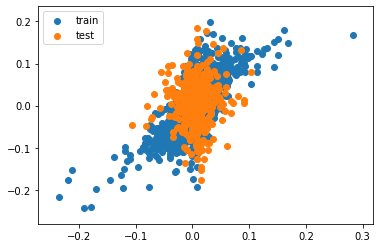

In [69]:
# Evaluate R^2 scores
train_preds = model_3.predict(scaled_train_features)
test_preds = model_3.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets,test_preds))

# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds,test_targets,label='test')  # plot test set
plt.legend(); plt.show()

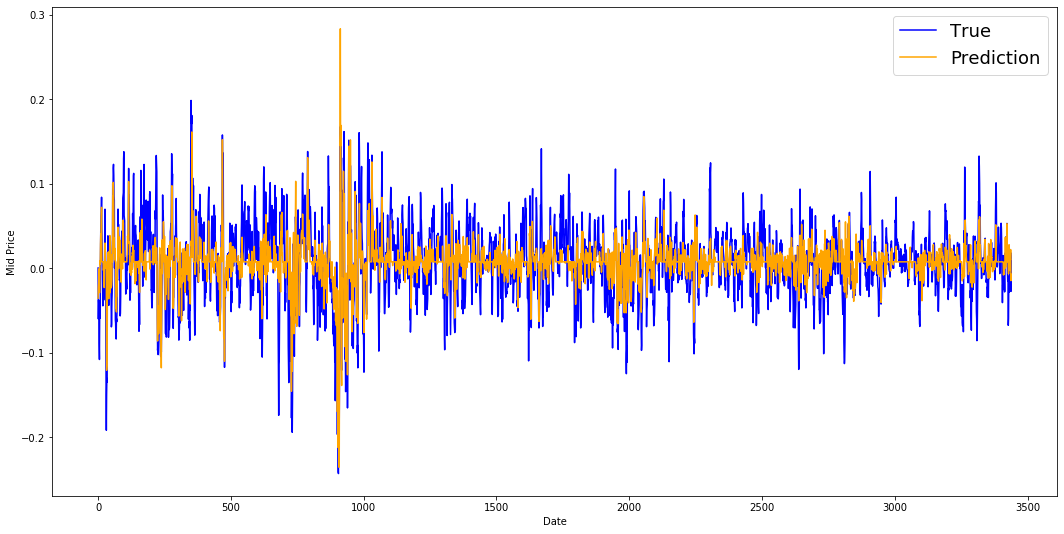

In [70]:
plt.figure(figsize = (18,9))
plt.plot(range(train_preds.shape[0]),train_targets,color='b',label='True')
plt.plot(range(train_preds.shape[0]),train_preds,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

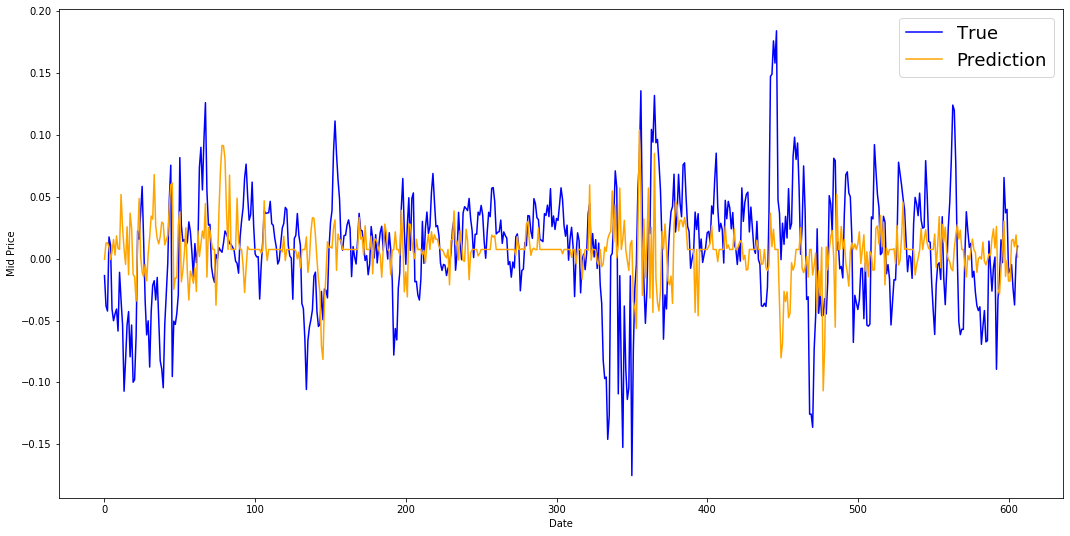

In [71]:
plt.figure(figsize = (18,9))
plt.plot(range(test_preds.shape[0]),test_targets,color='b',label='True')
plt.plot(range(test_preds.shape[0]),test_preds,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [72]:
# Make predictions from the 3 neural net models
train_pred1 = model_1.predict(scaled_train_features)
test_pred1 = model_1.predict(scaled_test_features)

train_pred2 = model_2.predict(scaled_train_features)
test_pred2 = model_2.predict(scaled_test_features)

train_pred3 = model_3.predict(scaled_train_features)
test_pred3 = model_3.predict(scaled_test_features)

# Horizontally stack predictions and take the average across rows
train_preds = np.mean(np.hstack((train_pred1, train_pred2, train_pred3)), axis=1)
test_preds = np.mean(np.hstack((test_pred1,test_pred2,test_pred3)), axis=1)
print(test_preds[-5:])

[0.02013084 0.01706669 0.01096279 0.01864252 0.00473558]


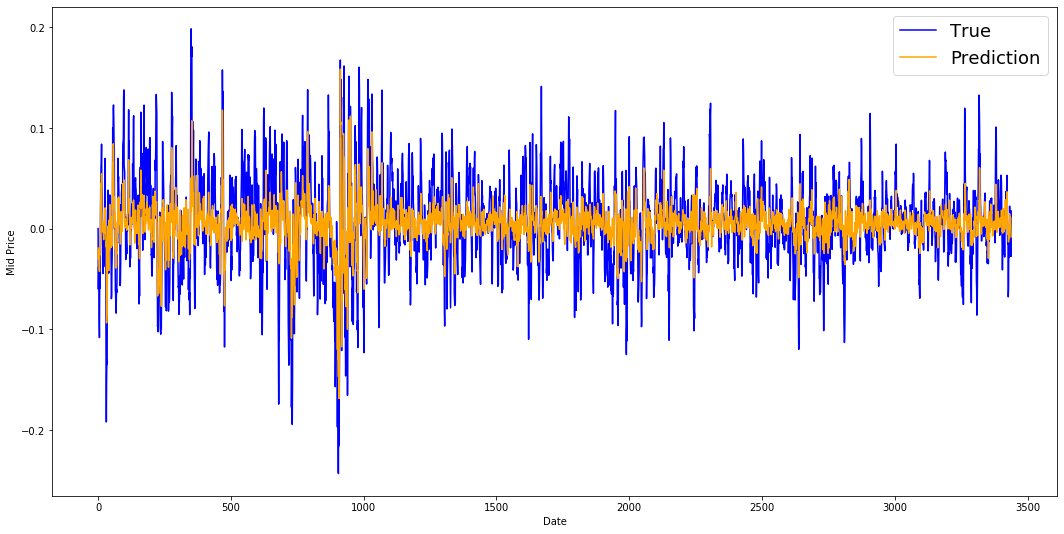

In [73]:
plt.figure(figsize = (18,9))
plt.plot(range(train_preds.shape[0]),train_targets,color='b',label='True')
plt.plot(range(train_preds.shape[0]),train_preds,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

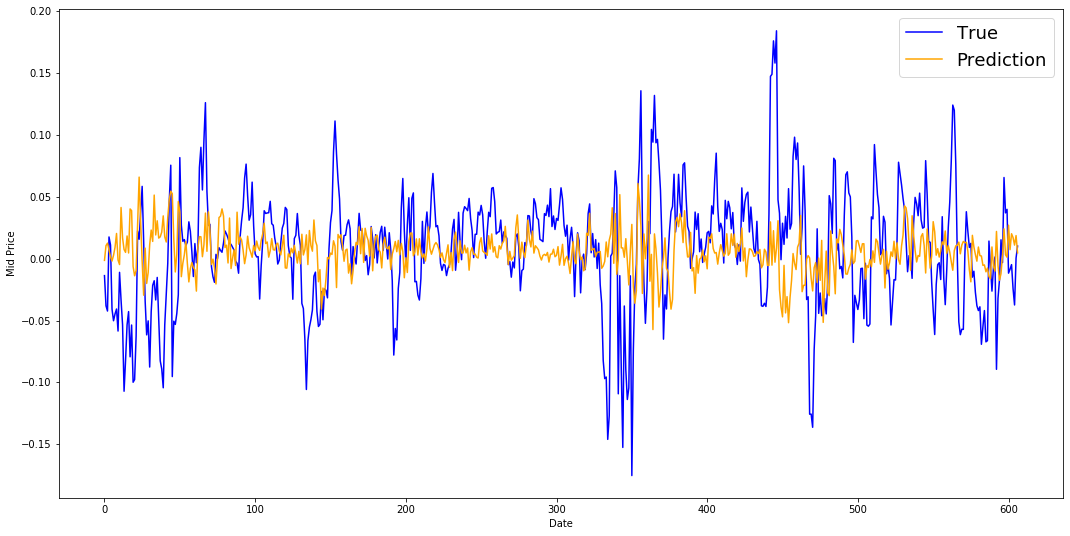

In [74]:
plt.figure(figsize = (18,9))
plt.plot(range(test_preds.shape[0]),test_targets,color='b',label='True')
plt.plot(range(test_preds.shape[0]),test_preds,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

0.48516527329306436
-0.10771665857191115


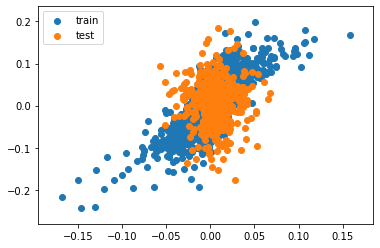

In [75]:
from sklearn.metrics import r2_score

# Evaluate the R^2 scores
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')
plt.legend(); plt.show()

In [76]:
from sklearn.metrics import mean_squared_error
from keras.layers import LSTM

In [77]:
scaled_train_features, train_targets= np.array(scaled_train_features), np.array(train_targets)
scaled_train_features = np.reshape(scaled_train_features, (scaled_train_features.shape[0],scaled_train_features.shape[1],1))

In [86]:
# Initialising the RNN
model4 = Sequential()

model4.add(LSTM(units = 200, return_sequences = True, input_shape = (scaled_train_features.shape[1], 1)))

# Adding a second LSTM layer and Dropout layer
model4.add(LSTM(units = 120, return_sequences = True))
#model4.add(Dropout(0.2))

# Adding a third LSTM layer and Dropout layer
model4.add(LSTM(units = 100, return_sequences = True))
#model4.add(Dropout(0.2))

# Adding a fourth LSTM layer and and Dropout layer
model4.add(LSTM(units = 50))
#model4.add(Dropout(0.2))

# Adding the output layer
# For Full connection layer we use dense
# As the output is 1D so we use unit=1
model4.add(Dense(units = 1))

Epoch 1/30
3439/3439 [==============================] - 10s 3ms/step - loss: 0.0021
Epoch 2/30
3439/3439 [==============================] - 8s 2ms/step - loss: 0.0021
Epoch 3/30
3439/3439 [==============================] - 9s 2ms/step - loss: 0.0021
Epoch 4/30
3439/3439 [==============================] - 9s 3ms/step - loss: 0.0021
Epoch 5/30
3439/3439 [==============================] - 9s 3ms/step - loss: 0.0021
Epoch 6/30
3439/3439 [==============================] - 10s 3ms/step - loss: 0.0021
Epoch 7/30
3439/3439 [==============================] - 9s 3ms/step - loss: 0.0021
Epoch 8/30
3439/3439 [==============================] - 11s 3ms/step - loss: 0.0021
Epoch 9/30
3439/3439 [==============================] - 11s 3ms/step - loss: 0.0021
Epoch 10/30
3439/3439 [==============================] - 11s 3ms/step - loss: 0.0021
Epoch 11/30
3439/3439 [==============================] - 11s 3ms/step - loss: 0.0021
Epoch 12/30
3439/3439 [==============================] - 11s 3ms/step - loss: 0

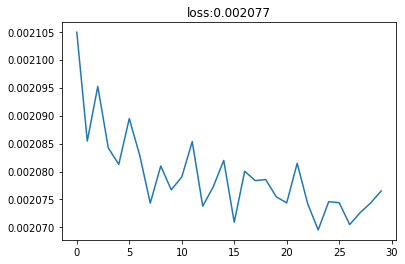

In [87]:
#compile and fit the model on 30 epochs
model4.compile(optimizer = 'adam', loss = 'mse')

history=model4.fit(scaled_train_features, train_targets, epochs = 30, batch_size = 20)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

In [88]:
scaled_test_features= np.array(scaled_test_features)

#Reshape the data into 3-D array
scaled_test_features = np.reshape(scaled_test_features, (scaled_test_features.shape[0],scaled_test_features.shape[1],1))

In [89]:
train_preds = model4.predict(scaled_train_features)
test_preds = model4.predict(scaled_test_features)

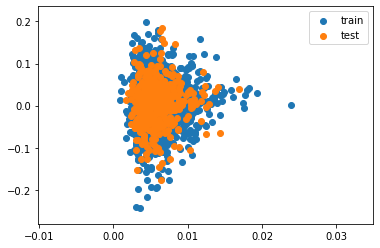

In [90]:
# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds,test_targets,label='test')  # plot test set
plt.legend(); plt.show()

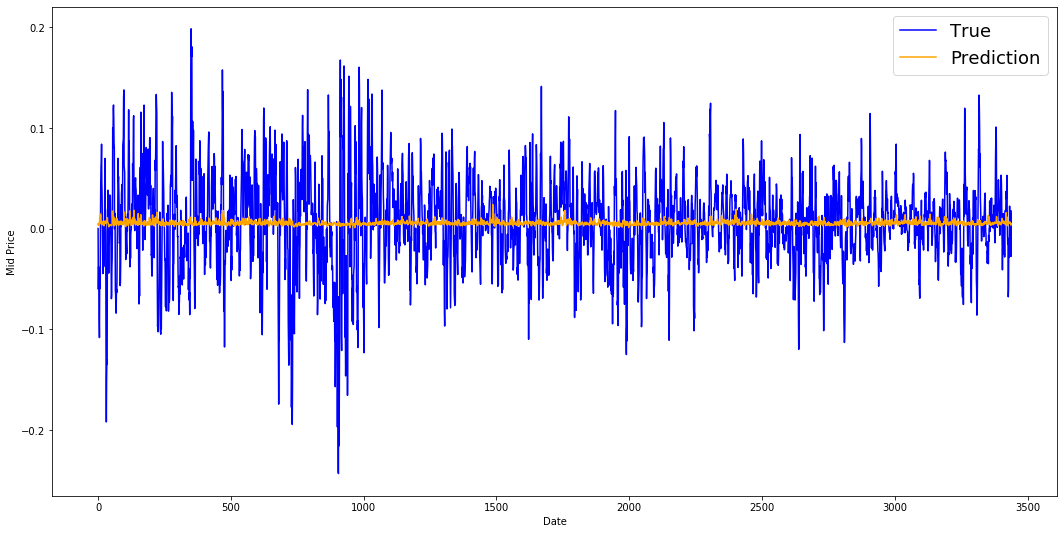

In [91]:
plt.figure(figsize = (18,9))
plt.plot(range(train_preds.shape[0]),train_targets,color='b',label='True')
plt.plot(range(train_preds.shape[0]),train_preds,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

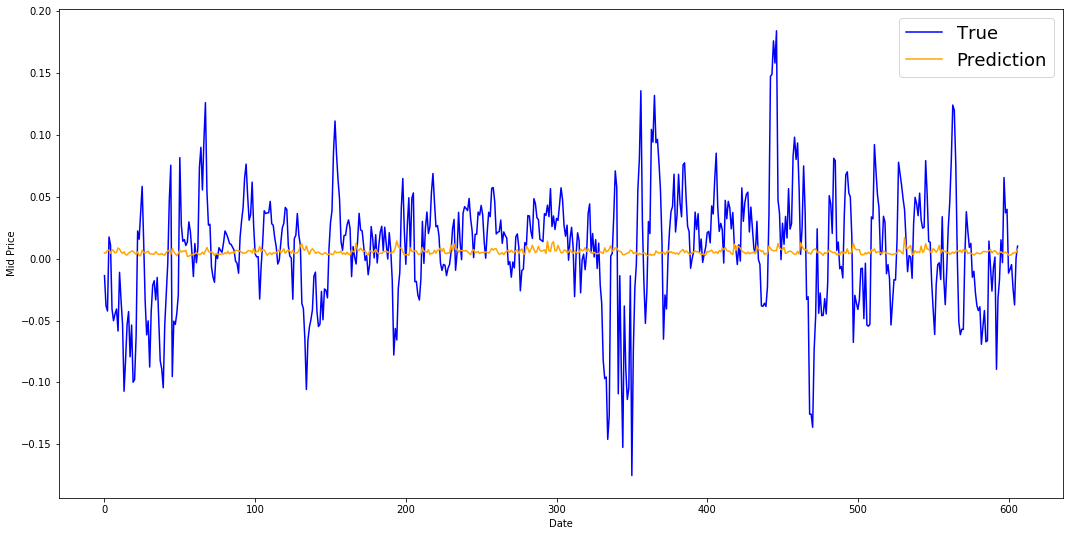

In [92]:
plt.figure(figsize = (18,9))
plt.plot(range(test_preds.shape[0]),test_targets,color='b',label='True')
plt.plot(range(test_preds.shape[0]),test_preds,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()